In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# "Unique" imports
import numpy.random as rnd
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
# pip3 install gym
# pip3 install gym[atari]

# w/o conda

import gym

In [3]:
env = gym.make('Breakout-v0')

In [4]:
obs = env.reset()

In [5]:
obs.shape # [width, height, channels]

(210, 160, 3)

In [6]:
img = env.render(mode="rgb_array")

<IPython.core.display.Javascript object>


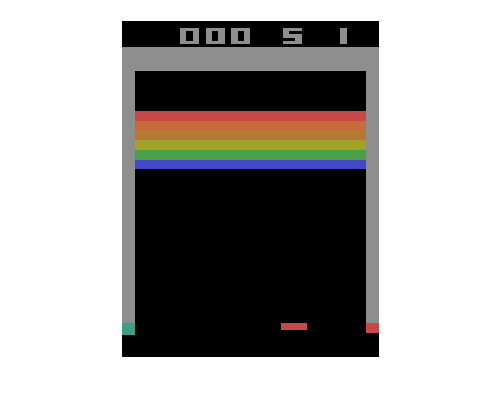

Saving figure Breakout


In [7]:
plt.figure(figsize=(5,4))
plt.imshow(img)
plt.axis("off")
save_fig("Breakout")
plt.show()

In [8]:
(img == obs).all()

True

In [8]:
def plot_environment(env, figsize=(5,4)):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [9]:
print(env.action_space)

Discrete(4)


<IPython.core.display.Javascript object>


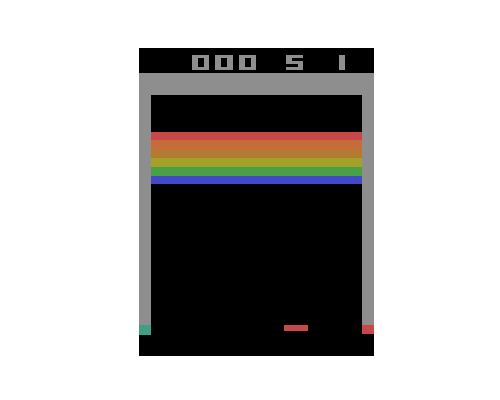

In [10]:
plot_environment(env)

In [12]:
obs, reward, done, info = env.step(0)

In [13]:
print (obs.shape,"\n", reward,"\n", done,"\n", info)

# When the game is over, the environment returns done=True:

(210, 160, 3) 
 0.0 
 False 
 {'ale.lives': 5}


In [14]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode="rgb_array")
    frames.append(img)
    if step % n_change_steps == 0:
        action = env.action_space.sample() # play randomly
    obs, reward, done, info = env.step(action)
    if done:
        break

In [12]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

<IPython.core.display.Javascript object>


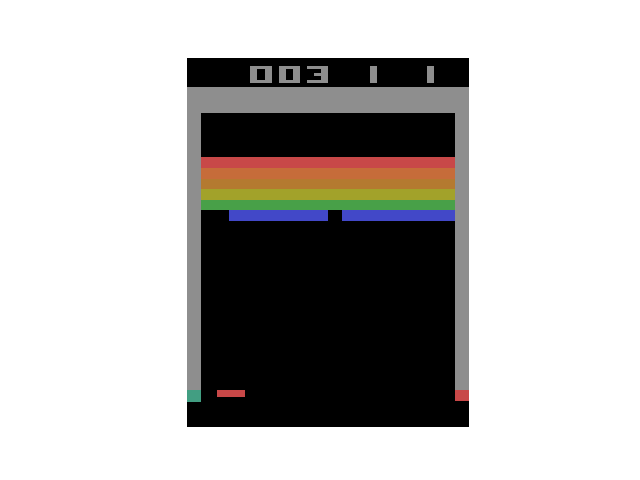

In [13]:
video = plot_animation(frames)
video.save("./images/BO_Initial.gif",dpi=80,writer="imagemagick")
#plt.show()


In [14]:
env.close()

## Preprocessing

In [15]:
mspacman_color = np.array([210, 164, 74]).mean()

def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.mean(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # Improve contrast
    img = (img - 128) / 128 - 1 # normalize from -1. to 1.
    return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

<IPython.core.display.Javascript object>


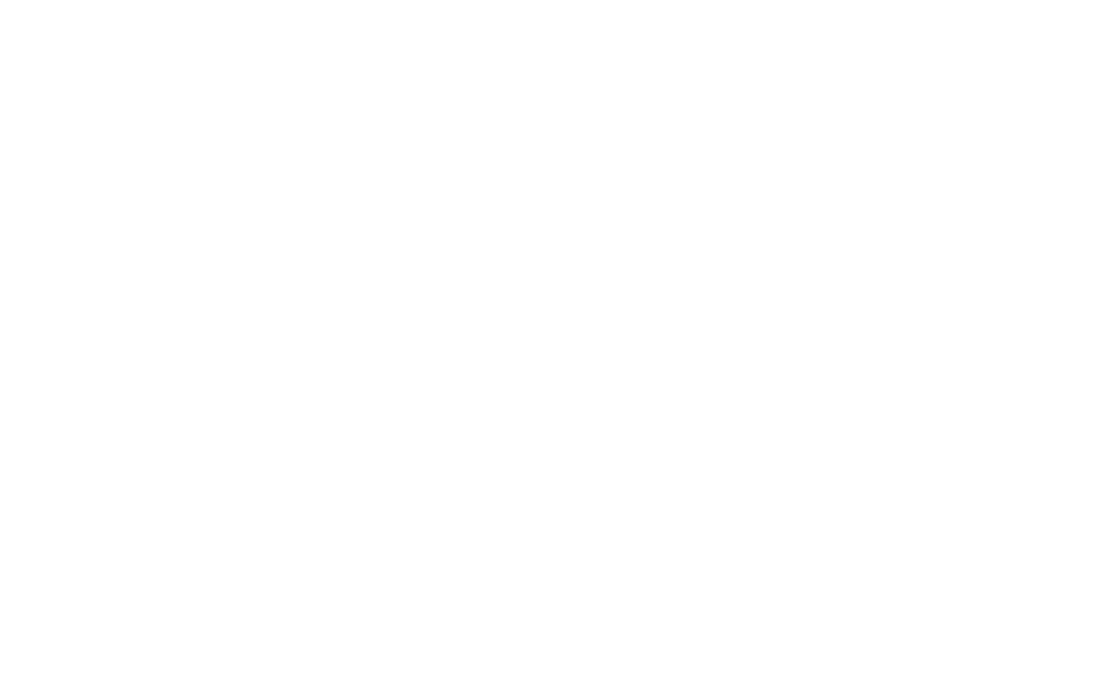

Saving figure preprocessing_plot


In [16]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88×80 greyscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
save_fig("preprocessing_plot")
plt.show()

# Build DQN

In [17]:
reset_graph()

input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"]*3 
conv_activation = [tf.nn.relu]*3
n_hidden_inputs = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n
initializer = tf.contrib.layers.variance_scaling_initializer()

learning_rate = 0.01

def q_network(X_state, scope):
    prev_layer = X_state
    conv_layers = []
    with tf.variable_scope(scope) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(conv_n_maps, conv_kernel_sizes, conv_strides, conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(prev_layer, filters=n_maps, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation, kernel_initializer=initializer)
            conv_layers.append(prev_layer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_inputs])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden, activation=hidden_activation, kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs)
    trainable_vars = {var.name[len(scope.name):]: var for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)}
    return outputs, trainable_vars

X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width, input_channels])
actor_q_values, actor_vars = q_network(X_state, scope="q_networks/actor")    # acts
critic_q_values, critic_vars = q_network(X_state, scope="q_networks/critic") # learns

copy_ops = [actor_var.assign(critic_vars[var_name])
            for var_name, actor_var in actor_vars.items()]
copy_critic_to_actor = tf.group(*copy_ops)

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(critic_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keep_dims=True)
    cost = tf.reduce_mean(tf.square(y - q_value))
    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(cost, global_step=global_step)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [18]:
actor_vars

{'/conv2d/bias:0': <tf.Variable 'q_networks/actor/conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 '/conv2d/kernel:0': <tf.Variable 'q_networks/actor/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>,
 '/conv2d_1/bias:0': <tf.Variable 'q_networks/actor/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_1/kernel:0': <tf.Variable 'q_networks/actor/conv2d_1/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 '/conv2d_2/bias:0': <tf.Variable 'q_networks/actor/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_2/kernel:0': <tf.Variable 'q_networks/actor/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 '/dense/bias:0': <tf.Variable 'q_networks/actor/dense/bias:0' shape=(512,) dtype=float32_ref>,
 '/dense/kernel:0': <tf.Variable 'q_networks/actor/dense/kernel:0' shape=(7040, 512) dtype=float32_ref>,
 '/dense_1/bias:0': <tf.Variable 'q_networks/actor/dense_1/bias:0' shape=(4,) dtype=float32_ref>,
 '/dense_1/kernel:0': <tf.Variable 'q_networks/actor/dense_1/kern

In [19]:
from collections import deque

replay_memory_size = 10000
replay_memory = deque([], maxlen=replay_memory_size)

def sample_memories(batch_size):
    indices = rnd.permutation(len(replay_memory))[:batch_size]
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for idx in indices:
        memory = replay_memory[idx]
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [20]:
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 50000
import sys

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if rnd.rand() < epsilon:
        return rnd.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

In [21]:
n_steps = 15000  # total number of training steps
training_start = 1000  # start training after 1,000 game iterations
training_interval = 3  # run a training step every 3 game iterations
save_steps = 50  # save the model every 50 training steps
copy_steps = 25  # copy the critic to the actor every 25 training steps
discount_rate = 0.95
skip_start = 90  # Skip the start of every game (it's just waiting time).
batch_size = 50
iteration = 0  # game iterations
checkpoint_path = "./saved/Breakout.ckpt"
done = True # env needs to be reset

with tf.Session() as sess:
    

#    if os.path.isfile(checkpoint_path):
    saver.restore(sess, checkpoint_path)
    training_start = 10

#    else:
#        init.run()

    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\rIteration {}\tTraining step {}/{} ({:.1f}%)".format(iteration, step, n_steps, step * 100 / n_steps), end="")
        if done: # game over, start again
            obs = env.reset()
            for skip in range(skip_start): # skip boring game iterations at the start of each game
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)

        # Actor evaluates what to do
        q_values = actor_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # Actor plays
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)

        # Let's memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        if iteration < training_start or iteration % training_interval != 0:
            continue
        
        # Critic learns
        X_state_val, X_action_val, rewards, X_next_state_val, continues = sample_memories(batch_size)
        next_q_values = actor_q_values.eval(feed_dict={X_state: X_next_state_val})
        y_val = rewards + continues * discount_rate * np.max(next_q_values, axis=1, keepdims=True)
        training_op.run(feed_dict={X_state: X_state_val, X_action: X_action_val, y: y_val})

        # Regularly copy critic to actor
        if step % copy_steps == 0:
            copy_critic_to_actor.run()

        # And save regularly
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

INFO:tensorflow:Restoring parameters from ./saved/Breakout.ckpt
Iteration 3606	Training step 14999/15000 (100.0%)

In [22]:
env = gym.make('Breakout-v0')
img = env.render(mode="rgb_array")

n_max_steps = 10000
frames = []

with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./saved/Breakout.ckpt")
    obs = env.reset()
    for step in range(n_max_steps):
        img = env.render(mode="rgb_array")
        frames.append(img)
        q_values = actor_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)
        obs, reward, done, info = env.step(action)
        if done:
            break

env.close()

INFO:tensorflow:Restoring parameters from ./saved/Breakout.ckpt


<IPython.core.display.Javascript object>


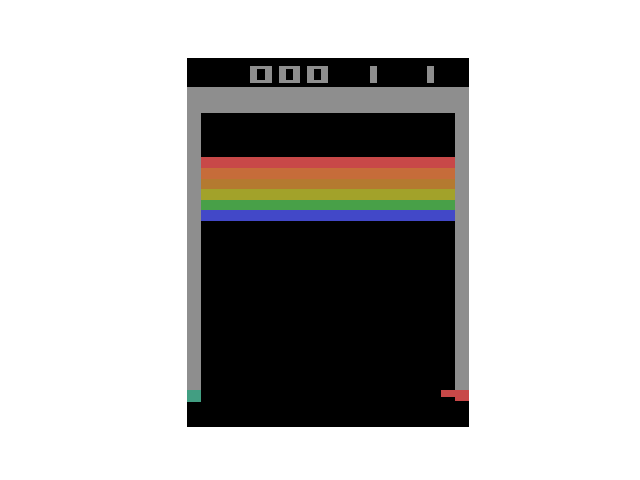

In [23]:
video = plot_animation(frames)
video.save("./images/BO_Learned.gif",dpi=80,writer="imagemagick")
#plt.show()